## Import dependencies

In [2]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re
import palettable

## get SSP emissions
from tools.RCMIP import *

GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Pandas options setup

pd.set_option('display.max_columns', 100)
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


# NROY Ensemble Generation

## Part I: the Global Warming Index

### required OLSE script:

In [2]:
# definition to compute the regressions:
def OLSE_NORM(X,Y,add_intercept=True):
    
    ## computes a multiple OLS regression over a field against several indices. First dimension is time, second is features (X), or targets (Y)
    
    if add_intercept:
    
        X_1 = np.concatenate((np.ones(X.shape[0])[:,np.newaxis],X),axis=1)
        
    else:
        
        X_1 = X.copy()
    
    B = np.dot( np.linalg.inv( np.dot( X_1.T , X_1 ) ) , np.dot( X_1.T , Y ) )
    
    e = Y - np.dot(X_1,B)
    
    SSE = np.sum(e**2,axis=0)

    SST = np.sum((Y - np.mean(Y,axis=0))**2,axis=0)

    R2 = 1 - SSE / SST

    MSE_var = SSE / (X_1.shape[0] - X_1.shape[-1])

    SE_B = np.sqrt( np.diag( np.linalg.inv( np.dot( X_1.T , X_1 ) ) )[:,np.newaxis] * MSE_var[np.newaxis,:] )
    
    return {'coefs':B[1:],'coef_err':SE_B[1:],'res':e,'intercept':B[0],'intercept_err':SE_B[0],'R2':R2}

### Retrieve observational GMST data

In [3]:
## Import data
baseline = ['1861','1880']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [4]:
import xarray as xr

ERA5 = xr.open_dataset('/home/leachl/Documents/Datasets/GMST/ERA5.nc').sel(expver=1).t2m#.squeeze().to_pandas()
weights = np.cos(np.deg2rad(ERA5.latitude))
ERA5_fldmean = ERA5.weighted(weights).mean(('longitude','latitude'))
ERA5_glob = (ERA5_fldmean.groupby("time.month") - ERA5_fldmean.groupby("time.month").mean('time')).to_pandas()

In [5]:
GSAT_to_GMST = OLSE_NORM(GMST_datasets.loc[ERA5_glob.index[0]:ERA5_glob.dropna().index[-1]].mean(axis=1).values[:,np.newaxis],ERA5_glob.dropna().values[:,np.newaxis])
print('GMST to GSAT scaling = ',round(GSAT_to_GMST['coefs'].flatten()[0],3),'+-',round(GSAT_to_GMST['coef_err'].flatten()[0],4))

GMST to GSAT scaling =  1.035 +- 0.0103


<AxesSubplot:>

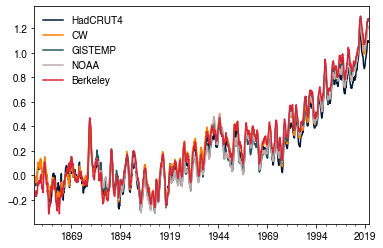

In [6]:
GMST_datasets.rolling(12).mean().plot()

In [7]:
## Import the observational uncertainty from HadCRUT

HadCRUT_ensmem_zip = ZipFile(BytesIO(requests.get('https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg_realisations.zip').content))
HadCRUT_ensmem_fnames = [x.filename for x in HadCRUT_ensmem_zip.infolist() if x.filename[-4:] == '.txt']
HadCRUT_ensmem_index = pd.read_csv(HadCRUT_ensmem_zip.open(HadCRUT_ensmem_fnames[0]),header=None,delim_whitespace=True,usecols=[0],index_col=0).index
# HadCRUT_ensmem_index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT_ensmem_index])
HadCRUT_ensmem = pd.concat([pd.read_csv(HadCRUT_ensmem_zip.open(x),header=None,delim_whitespace=True,usecols=[1]).iloc[:,0].rename(str(i)) for i,x in enumerate(HadCRUT_ensmem_fnames)],axis=1)
HadCRUT_ensmem.index = HadCRUT_ensmem_index

In [8]:
## import forcing ensemble: for now, use the most up-to-date copy I have (.idlsave)

# forcing_dataset = readsav('/home/leachl/Documents/Datasets/RF/1750_Oct2017_forcings.idlsave')
# rf_ant = pd.DataFrame(forcing_dataset['rf_anthro'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)
# rf_nat = pd.DataFrame(forcing_dataset['rf_nat'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)

### Generate forcing profiles

In [9]:
## creating a forcing response dataset

def generate_forcing(N):

    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp245_1750-2500.csv',index_col=0,dtype=float)
    erf_ar6 -= erf_ar6.loc[1750]
    
    ## generating many rf shapes for the GWI

    rf_factors = {}

    rf_factors['co2'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).co2*random_percentiles + ~(erf_ar6.mean()>0).co2*(1-random_percentiles))
    rf_factors['ch4'] = sp.stats.norm(1,0.28/1.645).rvs(N)#ppf((erf_ar6.mean()>0).ch4*random_percentiles + ~(erf_ar6.mean()>0).ch4*(1-random_percentiles))
    rf_factors['n2o'] = sp.stats.norm(1,0.2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).n2o*random_percentiles + ~(erf_ar6.mean()>0).n2o*(1-random_percentiles))
    rf_factors['other_wmghg'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).other_wmghg*random_percentiles + ~(erf_ar6.mean()>0).other_wmghg*(1-random_percentiles))
    rf_factors['o3_tropospheric'] = sp.stats.norm(1,0.5/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_tropospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_tropospheric*(1-random_percentiles))
    rf_factors['o3_stratospheric'] = sp.stats.norm(1,2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_stratospheric*(1-random_percentiles))
    rf_factors['h2o_stratospheric'] = sp.stats.norm(1,0.72/1.645).rvs(N)#ppf((erf_ar6.mean()>0).h2o_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).h2o_stratospheric*(1-random_percentiles))
    rf_factors['contrails'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).contrails*random_percentiles + ~(erf_ar6.mean()>0).contrails*(1-random_percentiles))
    rf_factors['land_use'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).land_use*random_percentiles + ~(erf_ar6.mean()>0).land_use*(1-random_percentiles))
    rf_factors['volcanic'] = sp.stats.norm(1,0.5/1.645).rvs(N)
    rf_factors['solar'] = sp.stats.norm(1,1/1.645).rvs(N)

    pct_5 = 0.04 / 0.08
    pct_95 = 0.18 / 0.08
    sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
    mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
    rf_factors['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu)).rvs(N)

    ant_rf_ensemble = np.zeros((270,N))
    nat_rf_ensemble = np.zeros((270,N))

    for agent in ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','land_use','bc_on_snow']:
        ant_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]

    for agent in ['volcanic','solar']:
        nat_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]

    ## aerosol distribution 

    ### generate the mean shape:

    RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
    RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
    RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

    RCMIP_so2_emms -= RCMIP_so2_emms[0,0]
    RCMIP_oc_emms -= RCMIP_oc_emms[0,0]
    RCMIP_bc_emms -= RCMIP_bc_emms[0,0]

    ERFari_coefs = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)
    ERFaci_coefs = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)

    beta = -1*np.exp(ERFaci_coefs['log_beta'].mean())
    s = np.exp(ERFaci_coefs['log_s'].mean())
    alpha = ERFaci_coefs['alpha'].mean()

    # ERFari_shape = ERFari_coefs.so2.mean() * RCMIP_so2_emms + ERFari_coefs.bc.mean() * RCMIP_bc_emms + ERFari_coefs.oc.mean() * RCMIP_oc_emms
    # ERFaci_shape = beta * np.log(1 + RCMIP_so2_emms / s) + alpha * ( RCMIP_oc_emms + RCMIP_bc_emms )

    ERFari_shape = erf_ar6.loc[1750:2019,['aerosol-radiation_interactions']].values.T
    ERFaci_shape = erf_ar6.loc[1750:2019,['aerosol-cloud_interactions']].values.T

    ## construct the Smith distributions 
    def fit_skewnorm(x,X,percentiles):
        distr = sp.stats.skewnorm(*x)
        return sum(abs(distr.ppf(percentiles) - X))

    ERFaci_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.13,0.59,1.17],[0.05,0.5,0.95]),method='nelder-mead').x
    ERFari_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.07,0.27,0.6],[0.05,0.5,0.95]),method='nelder-mead').x

    ERFaci_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFaci_smith_sknorm_params).rvs(N)[:,None]
    ERFari_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFari_smith_sknorm_params).rvs(N)[:,None]

    ERFari_samples = ERFari_smith_sknorm_distr / ERFari_shape[0,-1] * ERFari_shape
    ERFaci_samples = ERFaci_smith_sknorm_distr / ERFaci_shape[0,-1] * ERFaci_shape
    
    tot_aer = (ERFari_samples+ERFaci_samples).T

    ## Combine all anthro forcings
    ant_rf_ensemble += tot_aer
    
    ## 
    rf_nat = pd.DataFrame(nat_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']])).loc[:2017]

    rf_ant = pd.DataFrame(ant_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']])).loc[:2017]
    
    return rf_ant,rf_nat

<AxesSubplot:>

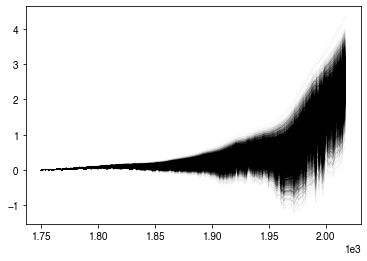

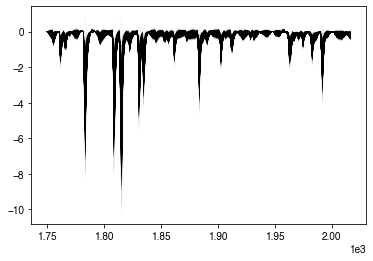

In [10]:
N_forc = 10000

rf_ant,rf_nat = generate_forcing(N_forc)

rf_ant.plot(legend=None,lw=0.02,c='k')

rf_nat.plot(legend=None,lw=0.02,c='k')

### Combine HadCRUT uncertainty with 5-dataset mean signal

In [11]:
## generate the uncertain temperature array:

temp_obs_med = GMST_datasets.mean(axis=1).loc[:str(int(rf_ant.index[-1]))].resample('Y').mean().values

temp_obs_unc = HadCRUT_ensmem.loc[:rf_ant.index[-1]].values - HadCRUT_ensmem.loc[:rf_ant.index[-1]].median(axis=1)[:,np.newaxis]

temp_obs_full = temp_obs_med[:,np.newaxis] + temp_obs_unc

#### Alternative aerosol generation with varying shapes (work-in-progress):

In [12]:
# ## New aerosol generation methodology, following Smith et al (2020) ; multivariate gaussian distribution, sample parameters, generate shapes from emission data.
# ERFari_params = pd.DataFrame(data=np.array([[ 3.25934432e-02, -3.46653116e-04, -2.48761587e-03],
#        [ 2.48231885e-02, -1.26321908e-02, -9.42090973e-04],
#        [ 2.68560170e-02, -2.08950151e-03, -2.60579679e-03],
#        [ 1.01700746e-01, -3.04192033e-02, -2.63868473e-03],
#        [ 1.46132214e-01, -4.41485999e-02, -6.67827786e-03],
#        [ 1.95732170e-03,  4.15481407e-03, -2.90822562e-03],
#        [-5.61261154e-02,  8.85201623e-03, -7.47602910e-04],
#        [ 3.87211606e-02, -1.42408227e-02, -1.78155606e-03],
#        [ 3.02173214e-03, -3.40228173e-03, -1.25702781e-03],
#        [ 2.54832726e-03,  6.32322444e-05, -2.38863636e-03]]),index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

# ERFari_sfs = sp.stats.multivariate_normal(ERFari_params.mean(),ERFari_params.cov()).rvs(N)
# ERFari_samples = (ERFari_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

# ### LINEAR ERFaci params
# # ERFaci_params = pd.DataFrame(data=np.array([[-0.23977316,  0.05033984, -0.0026841 ],
# #        [-0.03596736, -0.0061301 , -0.00999338],
# #        [-0.02306089, -0.00397075, -0.00440759],
# #        [-0.04100239, -0.00815999, -0.00296047],
# #        [-0.11952911,  0.01185454, -0.00136009],
# #        [-0.0751146 ,  0.0115965 , -0.00595064],
# #        [-0.00958696,  0.00027465, -0.00252801],
# #        [-0.10616509,  0.01464634, -0.00292868],
# #        [ 0.02490414, -0.02261304, -0.00721553],
# #        [ 0.06822656, -0.01548075, -0.01065098]])
# # ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
# #        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
# #        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

# ### LOG so2 ERFaci params
# ERFaci_params = pd.DataFrame(data=np.array([[-8.04936152e-01, -4.33765114e+00, -1.76516101e-02],
#        [ 4.20348167e-01, -4.19165818e+00, -1.57827154e-02],
#        [ 1.67034191e+00, -5.34562320e+00, -8.80674737e-03],
#        [ 2.25088976e+00, -5.57251763e+00, -1.19361347e-02],
#        [-1.80621064e+00, -4.82004944e+00, -1.88411062e-02],
#        [-1.48244252e-01, -4.48450777e+00, -6.70740113e-03],
#        [ 1.03705925e+00, -5.88364385e+00, -1.91422284e-03],
#        [-1.00837014e+00, -4.73118298e+00, -1.30437040e-02],
#        [ 2.07731610e+00, -5.03084334e+00, -1.39245898e-02],
#        [-2.52178641e-01, -3.93423009e+00,  3.35367830e-03]])

# ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['log_beta', 'log_beta_s', 'alpha'])

# # ERFaci_params.loc[:,'so2_logcoef'] = np.log(-1*ERFaci_params.loc[:,'so2_logcoef'])

# ### LINEAR ERFaci params
# # ERFaci_sfs = sp.stats.multivariate_normal(ERFaci_params.mean(),ERFaci_params.cov()).rvs(N)
# # ERFaci_samples = (ERFaci_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

# ### LOG so2 ERFaci params
# beta_samples = -1 * np.exp( sp.stats.norm(ERFaci_params['log_beta'].mean(),ERFaci_params['log_beta'].std()).rvs(N) )[...,None]
# beta_s_samples = np.exp( sp.stats.norm(ERFaci_params['log_beta_s'].mean(),ERFaci_params['log_beta_s'].std()).rvs(N) )[...,None]
# s_samples = -1 * beta_samples / beta_s_samples
# alpha_samples = sp.stats.norm(ERFaci_params['alpha'].mean(),ERFaci_params['alpha'].std()).rvs(N)[...,None]

# RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
# RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
# RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

# ERFaci_samples = beta_samples * np.log(1+RCMIP_so2_emms/s_samples) + alpha_samples * ( RCMIP_oc_emms+RCMIP_bc_emms )

### Generate response parameters

In [13]:
def generate_response_params():

    ## create the response parameter ranges:

    ### based on inferred ranges from CMIP6 - 18 combinations
    response_names = ['response_'+str(x) for x in np.arange(24)]
    response_params = pd.DataFrame(index=['d','q'],columns = pd.MultiIndex.from_product([response_names,[1,2,3]])).apply(pd.to_numeric)
    response_params.loc[:] = 0

    d1_range = [0.2,0.8,1.4,2]
    d2_range = [4,8,12,16]
    d3_range = [100,200,400,800]
    q1_range = [0.04,0.16,0.28,0.4]

    RWF_range = [0.3 , 0.4 , 0.5, 0.6, 0.7, 0.8]
    ECS=3

    i=0
    for d_num in np.arange(4):
        for RWF in RWF_range:
            response_params.loc['d',(response_names[i],1)] = d1_range[d_num]
            response_params.loc['d',(response_names[i],2)] = d2_range[d_num]
            response_params.loc['d',(response_names[i],3)] = d3_range[d_num]
            response_params.loc['q',(response_names[i],1)] = q1_range[d_num]

            q2,q3 = sp.optimize.root(lambda x: q_to_tcr_ecs(response_params.reindex([response_names[i]],axis=1,level=0) + [[0,0],[0,x[0]],[0,x[1]]],F_2x=3.76).values.flatten() - np.array([ECS,ECS*RWF]),x0=np.array([0.32,0.47]),method='lm').x

            response_params.loc['q',(response_names[i],2)] = q2
            response_params.loc['q',(response_names[i],3)] = q3

            i+=1

    ## remove any that are unphysical (negative parameters)

    response_params = response_params.reindex([i for i,x in ((response_params<0).sum().unstack().sum(axis=1)==1).iteritems() if not x],axis=1,level=0)
    
    return response_params

In [14]:
response_params = generate_response_params()

## Generate temperature profiles:

In [15]:
## generate the temperature responses:

null_gas_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',header=[0,1],index_col=0).reindex(['carbon_dioxide'],axis=1,level=1)
##
temp_ant = run_GIR(emissions_in=return_empty_emissions(rf_ant,gases_in=['carbon_dioxide']),gas_parameters=null_gas_params,forcing_in=rf_ant,thermal_parameters=response_params)['T'].droplevel(1,axis=1)
temp_nat = run_GIR(emissions_in=return_empty_emissions(rf_nat,gases_in=['carbon_dioxide']),gas_parameters=null_gas_params,forcing_in=rf_nat,thermal_parameters=response_params)['T'].droplevel(1,axis=1)

Integrating 10000 scenarios, 1 gas cycle parameter sets, 18 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1750 and 2017...


100%|██████████| 267/267 [00:06<00:00, 44.31 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 18 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1750 and 2017...


100%|██████████| 267/267 [00:05<00:00, 45.47 timestep/s]


### Regress temp profiles vs observed temps

In [16]:
ant_coefs = np.zeros((100,temp_ant.shape[1]))
nat_coefs = np.zeros((100,temp_nat.shape[1]))
R2_vals = np.zeros(1000)

for i in tqdm.tqdm(np.arange(ant_coefs.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,temp_obs_full)
    ant_coefs[:,i] = _lreg_coefs['coefs'][0]
    nat_coefs[:,i] = _lreg_coefs['coefs'][1]
    R2_vals = _lreg_coefs['R2']

100%|██████████| 180000/180000 [05:53<00:00, 508.86it/s]


### Retrieve CMIP6 internal variability & subsample

In [17]:
## computing the uncertainty from internal variability

def generate_IV():
    ### get internal variability timeseries:

    piControl_data = pd.read_csv('../tools/cmip6_data/piControl.csv',index_col=0)
    for i,x in enumerate(['source','member','variable']):
        piControl_data.loc[x] = [x.split('_')[i+1] for x in piControl_data.columns]

    CMIP6_int_var=piControl_data.T.set_index(['source','member','variable']).T.xs('tas',axis=1,level=-1).apply(pd.to_numeric)

    ### subsample 100 * 170 year slices
    ### check if drift, discard if drift
    ### randomly pick one non-drifting sample

    CMIP6_int_var_samples = pd.DataFrame(index=np.arange(170),columns=CMIP6_int_var.columns)
    for model,data in CMIP6_int_var.iteritems():
        arr = data.dropna().values
        chunksize = arr.size
        if chunksize<170:
            continue
        starting_points = np.random.choice(np.arange(chunksize-170),100)
        nodrift_points = []
        for s in starting_points:
            subarr = arr[s:s+170]
            drift = sp.stats.linregress(np.arange(170),subarr).slope
            if abs(drift)*100>0.15:
                continue
            else:
                nodrift_points+=[s]
        chosen_start = np.random.choice(nodrift_points)
        CMIP6_int_var_samples.loc[:,model] = arr[chosen_start:chosen_start+170] - arr[chosen_start:chosen_start+170].mean()

    ### remove model degeneracies (take first member of each model):
    models = []
    chosen_members = []
    for model,data in CMIP6_int_var_samples.dropna(axis=1).iteritems():
        if model[0] in models:
            continue
        else:
            chosen_members+=[model]
            models+=[model[0]]

    return CMIP6_int_var_samples[chosen_members]

In [35]:
CMIP6_int_var_samples_nondeg = pd.concat([generate_IV(),generate_IV()],axis=1)

/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

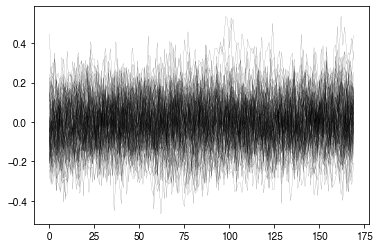

In [36]:
CMIP6_int_var_samples_nondeg.plot(legend=None,lw=0.1,c='k')

### Regress temp profiles vs internal variability

In [37]:
ant_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_ant.shape[1]))
nat_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_nat.shape[1]))

for i in tqdm.tqdm(np.arange(ant_coefs_iv.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,CMIP6_int_var_samples_nondeg.values[:168])['coefs']
    ant_coefs_iv[:,i] = _lreg_coefs[0]
    nat_coefs_iv[:,i] = _lreg_coefs[1]

100%|██████████| 180000/180000 [05:58<00:00, 502.51it/s]


(array([ 1.,  0.,  3.,  3.,  9., 17., 24., 20., 13.,  2.,  6.,  2.,  1.,
         1.]),
 array([-0.33070828, -0.27999792, -0.22928757, -0.17857722, -0.12786687,
        -0.07715651, -0.02644616,  0.02426419,  0.07497455,  0.1256849 ,
         0.17639525,  0.22710561,  0.27781596,  0.32852631,  0.37923667]),
 <BarContainer object of 14 artists>)

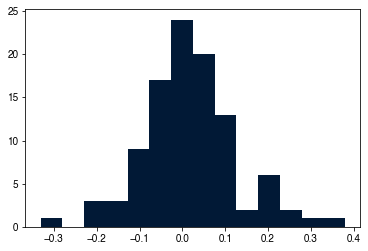

In [38]:
plt.hist(ant_coefs_iv.mean(axis=1))

### Reshape inputs for multiplication with OLSE coefficients

In [39]:
chosen_year = 2014

temp_ant_arr = (temp_ant.loc[chosen_year]-temp_ant.loc[1861:1880].mean()).values.reshape(N_forc,18)
rate_ant_arr = OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'].reshape(N_forc,18)

temp_nat_arr = (temp_nat.loc[chosen_year]-temp_nat.loc[1861:1880].mean()).values.reshape(N_forc,18)
rate_nat_arr = OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'].reshape(N_forc,18)

### Compute GWI & save

In [40]:
# np.save("../Parameter_Sets/NROY_GWI_informed/GWI_distribution/ant_level_attr",(ant_coefs.reshape(-1,N_forc,18)*temp_ant_arr)[:,None,...] + (ant_coefs_iv.reshape(-1,N_forc,18)*temp_ant_arr)[None,...])
# np.save("../Parameter_Sets/NROY_GWI_informed/GWI_distribution/nat_level_attr",(nat_coefs.reshape(-1,N_forc,18)*temp_nat_arr)[:,None,...] + (nat_coefs_iv.reshape(-1,N_forc,18)*temp_nat_arr)[None,...])

# np.save("../Parameter_Sets/NROY_GWI_informed/GWI_distribution/ant_rate_attr",(ant_coefs.reshape(-1,N_forc,18)*rate_ant_arr)[:,None,...] + (ant_coefs_iv.reshape(-1,N_forc,18)*rate_ant_arr)[None,...])
# np.save("../Parameter_Sets/NROY_GWI_informed/GWI_distribution/nat_rate_attr",(nat_coefs.reshape(-1,N_forc,18)*rate_nat_arr)[:,None,...] + (nat_coefs_iv.reshape(-1,N_forc,18)*rate_nat_arr)[None,...])

### Check projection of each dimension on probability space

In [41]:
temp_attr_ant = np.load('../Parameter_Sets/NROY_GWI_informed/GWI_distribution/ant_level_attr.npy',mmap_mode='r')
temp_attr_nat = np.load('../Parameter_Sets/NROY_GWI_informed/GWI_distribution/nat_level_attr.npy',mmap_mode='r')

temp_rate_attr_ant = np.load('../Parameter_Sets/NROY_GWI_informed/GWI_distribution/ant_rate_attr.npy',mmap_mode='r')
temp_rate_attr_nat = np.load('../Parameter_Sets/NROY_GWI_informed/GWI_distribution/nat_rate_attr.npy',mmap_mode='r')

Text(0, 0.5, 'rate of temperature change over 2010-2014 / K decade$^{-1}$')

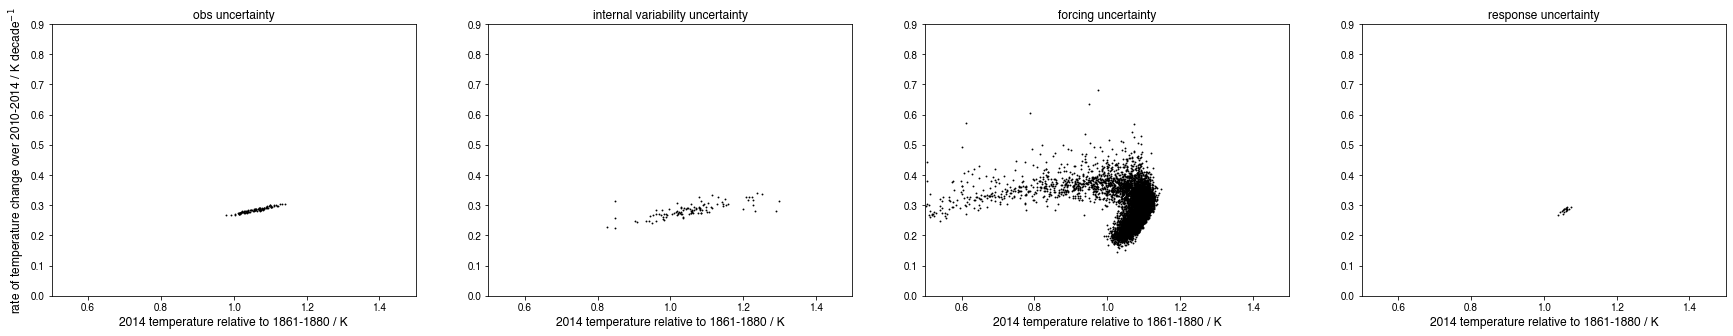

In [42]:
fig,ax=plt.subplots(1,4,figsize=(30,5))
# ax[0].hist2d((temp_attr_ant_and_iv+temp_attr_nat_and_iv).flatten(),10*(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv).flatten(),bins=500,cmap='binary',density=True)

for i,source in enumerate(['obs','internal variability','forcing','response']):
    print('computing '+source,end='\r')
    axes = tuple((np.arange(1,4)+i)%4)
    ax[i].scatter(temp_attr_ant.mean(axis=axes)+temp_attr_nat.mean(axis=axes),10*(temp_rate_attr_ant.mean(axis=axes)+temp_rate_attr_nat.mean(axis=axes)),color='k',marker='.',s=3)
    ax[i].set_title(source+' uncertainty')
    
[a.set_xlim(0.5,1.5) for a in ax]
[a.set_ylim(0.0,0.9) for a in ax]
[a.set_xlabel('2014 temperature relative to 1861-1880 / K',fontsize=12) for a in ax]
ax[0].set_ylabel('rate of temperature change over 2010-2014 / K decade$^{-1}$',fontsize=12)
# ax[0].set_title('FULL uncertainty',fontsize=12)